In [412]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
from numpy.random import default_rng
# plotting + misc tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import seaborn
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [406]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.logspace(0,2,20)
n = 1000
N = 10000
mu = 1.2e-8
cutoff = 1 # freq of 0.5%

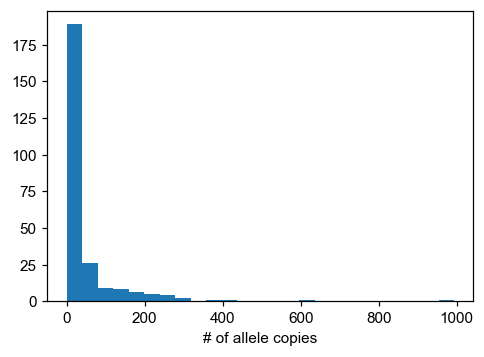

Text(0.5, 0, 'age of allele')

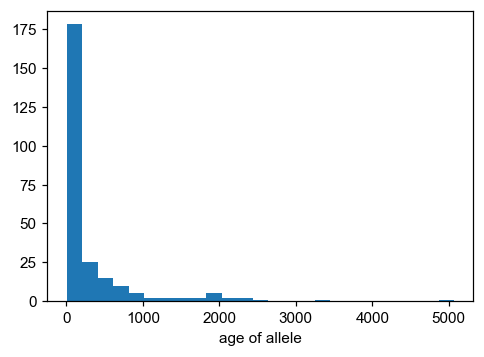

In [408]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("PReFerSims/outfiles/Bottleneck.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(20000,80000),np.repeat(2000,2000)))/2
df1
df1['sXl'] = rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele')

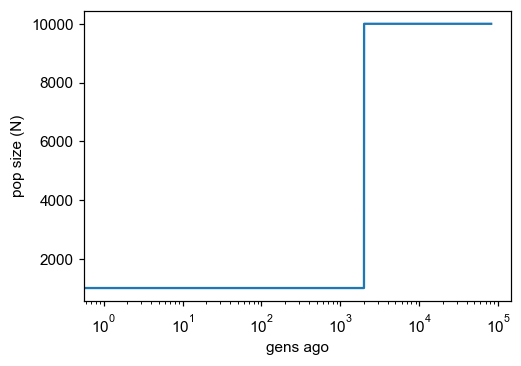

In [409]:
## creating a database of P(X, a | s) with dicts for different s values
up_xa_s = {}
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    # up_xa_s[g] = run_mom_iterate_changing(n, 0.5*g/Nc[0], Nc, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

In [414]:
## inference procedure (plot the loglik surfaces)
# dat = df1.sample(frac=0.5).to_numpy(dtype='int64')
# sin_onlyfreq = np.empty(len(gamma))
# sin_onlyage = np.empty(len(gamma))
# for ig, g in enumerate(gamma):
#     # sum log prob for each locus
#     sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1))
#     sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=1))
# print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])
mle = get_boot_ci(dat,nsamps=len(dat),cutoff=1)
mle

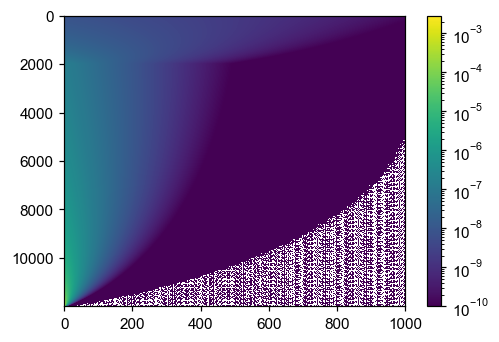

In [78]:
plt.imshow(up_xa_s[gamma[10]],aspect='auto',norm=colors.LogNorm(vmin=1e-10)); plt.colorbar(); plt.show()

In [317]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

-1.0
-5.455594781168519


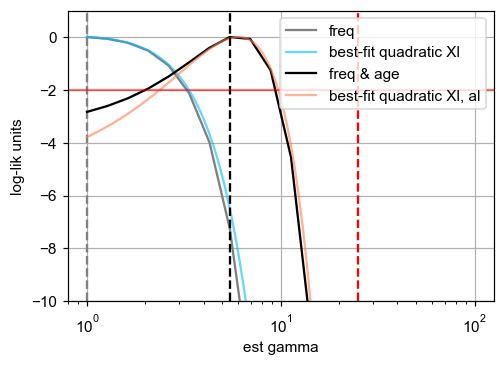

In [318]:
plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'][0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
# plt.vlines(get_ci(sin_onlyage,gamma),ymin=-10.,ymax=0.,color='k',ls='-.')
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

2. Expansion.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of recent expansion 200 gens ago to 200k inds)

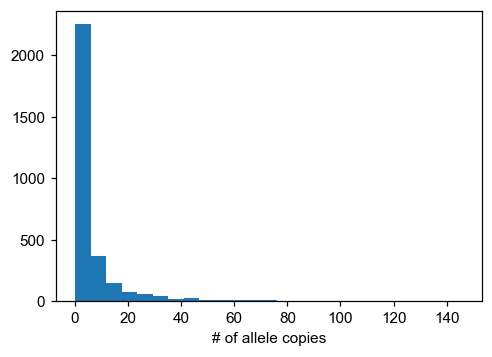

Text(0.5, 0, 'age of allele')

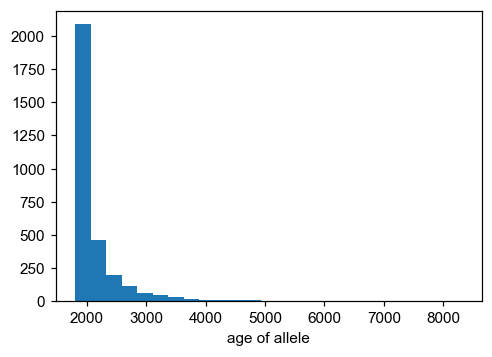

In [307]:
df1 = pd.read_csv("PReFerSims/outfiles/Expansion.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(20000,20000),np.repeat(200000,200)))/2
df1['sXl'] = rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
df1 
dat = df1.to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele')

In [266]:
up_xa_s = {}
for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate_changing(n, 0.5*g/Nc[0], Nc, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

array([-0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000,
       -0.000, -0.000, -0.001, -0.001, -0.001, -0.001, -0.001, -0.002,
       -0.002, -0.003, -0.004, -0.005])

[]

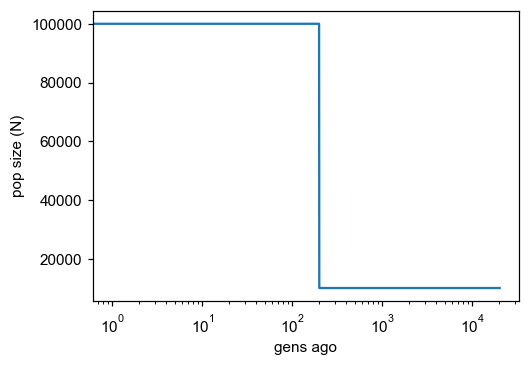

In [221]:
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()

In [267]:
## inference procedure (plot the loglik surfaces)
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=1))

-1.0
-1.0


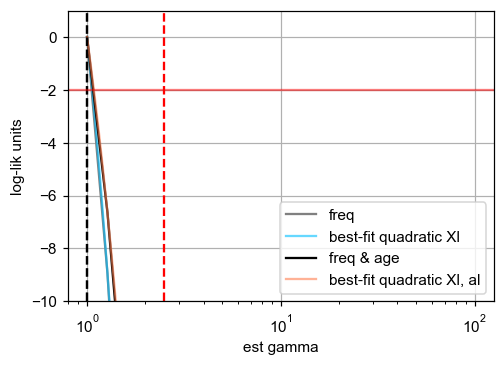

In [274]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'].iloc[0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

### Constant size demographic history with Boyko DFE parameters

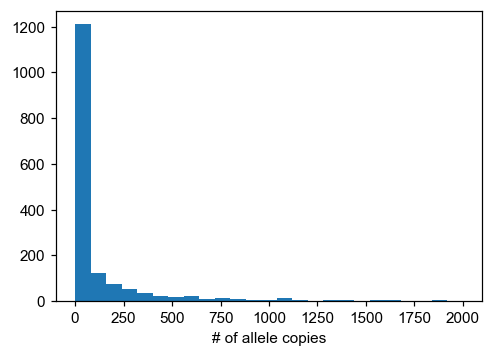

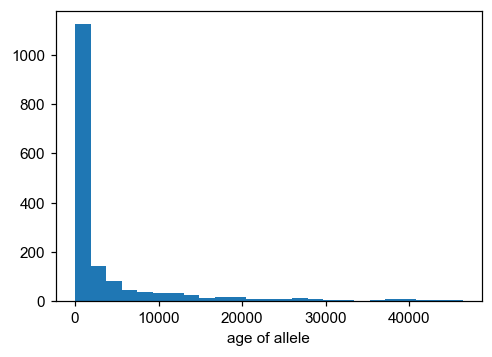

Text(0.5, 0, 'simulated gamma')

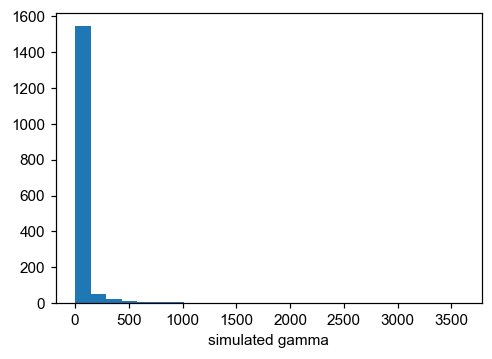

In [369]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("PReFerSims/outfiles/ConstantSizeBoyko.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = rng.binomial(n=n, p=df1['Xl'])
df1['al'] = 100000+1 - df1['al']
df1 = df1.loc[df1['al']<50000,:]
dat = df1.to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
plt.hist(df1['gamma'],25); plt.xlabel('simulated gamma')

In [359]:
## creating a database of P(X, a | s) with dicts for different s values
up_xa_s = {}

for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    # up_xa_s[g] = run_mom_iterate_changing(n, 0.5*g/Nc[0], Nc, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g] = run_mom_iterate_constant(50000, 2000, 0.5*g/10000, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

Text(0, 0.5, 'proportion of sites')

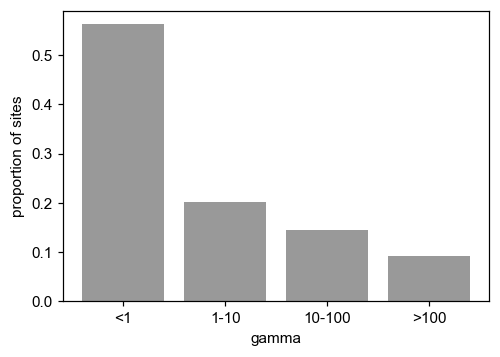

In [341]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.8)
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel('gamma'); plt.ylabel('proportion of sites')

In [387]:
# np.sum((df1['gamma']>1) & (df1['gamma']<10))/1692


339

In [401]:
## inference procedure (plot the loglik surfaces)
## need to do it separately for each bin of gamma 
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    # sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[(df1['gamma']>100) & (df1['gamma']<10),5], cutoff=1))
    # sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[(df1['gamma']>1) & (df1['gamma']<10),5], dat[(df1['gamma']>1) & (df1['gamma']<10),3], cutoff=1))
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[(df1['gamma']<1),5], cutoff=1))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[(df1['gamma']<1),5], dat[(df1['gamma']<1),3], cutoff=1))

In [403]:
# print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])
# get_ci(sin_onlyfreq, gamma), get_ci(sin_onlyage, gamma)
gamma

array([-1.000, -1.274, -1.624, -2.069, -2.637, -3.360, -4.281, -5.456,
       -6.952, -8.859, -11.288, -14.384, -18.330, -23.357, -29.764,
       -37.927, -48.329, -61.585, -78.476, -100.000])